In [1]:
import os
os.chdir(os.path.abspath(".."))

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from dataio import load_metadataset, load_rmses
from metamodel import build_baseline, build_regression_topline

from sklearn.feature_selection import SelectFpr, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from MCM import MCM

--- Analysing catch22 features ---


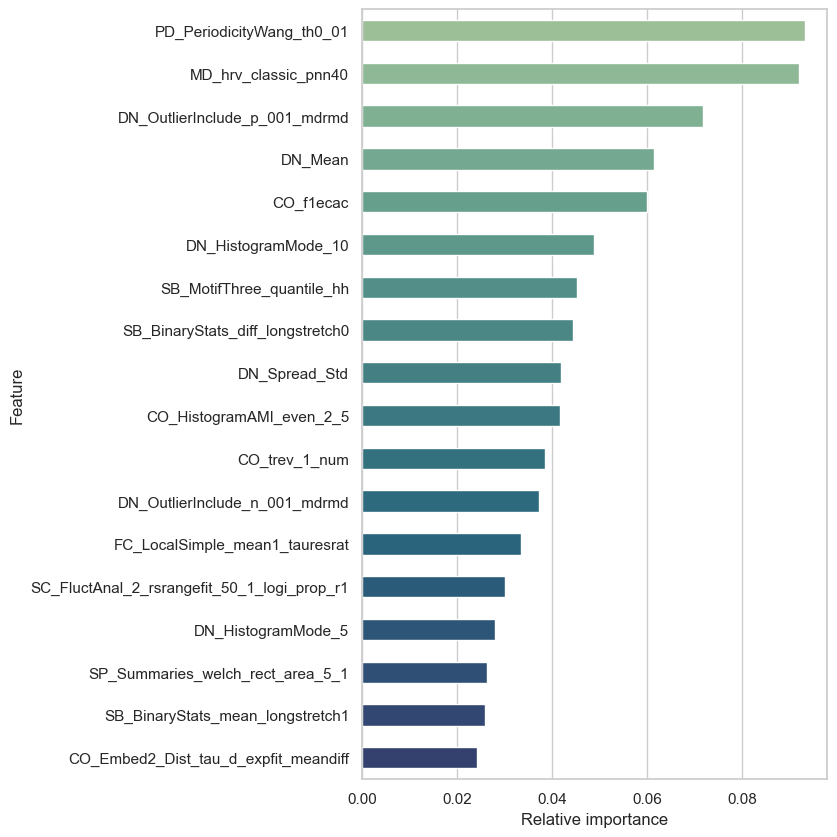

--- Analysing minimal features ---


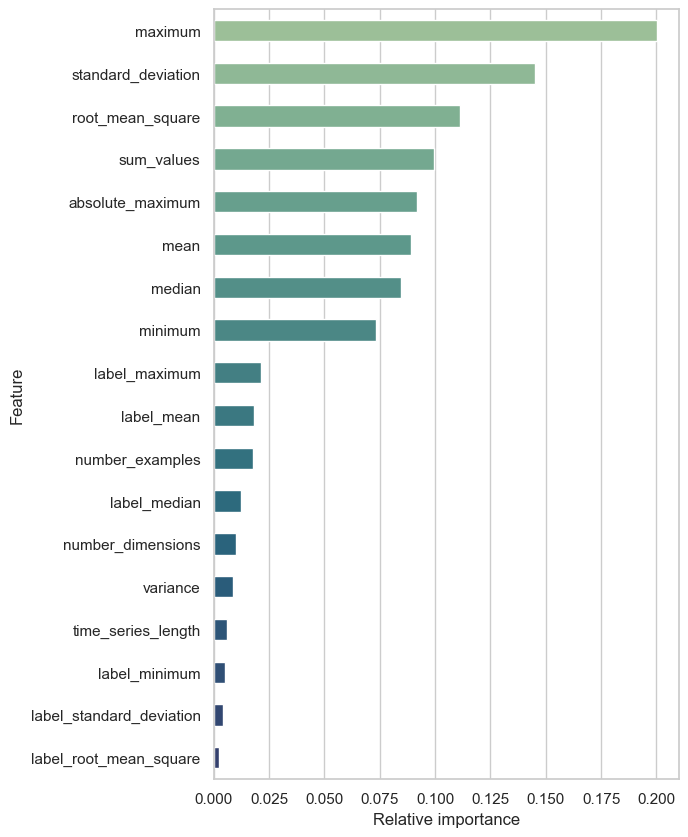

--- Analysing efficient features ---


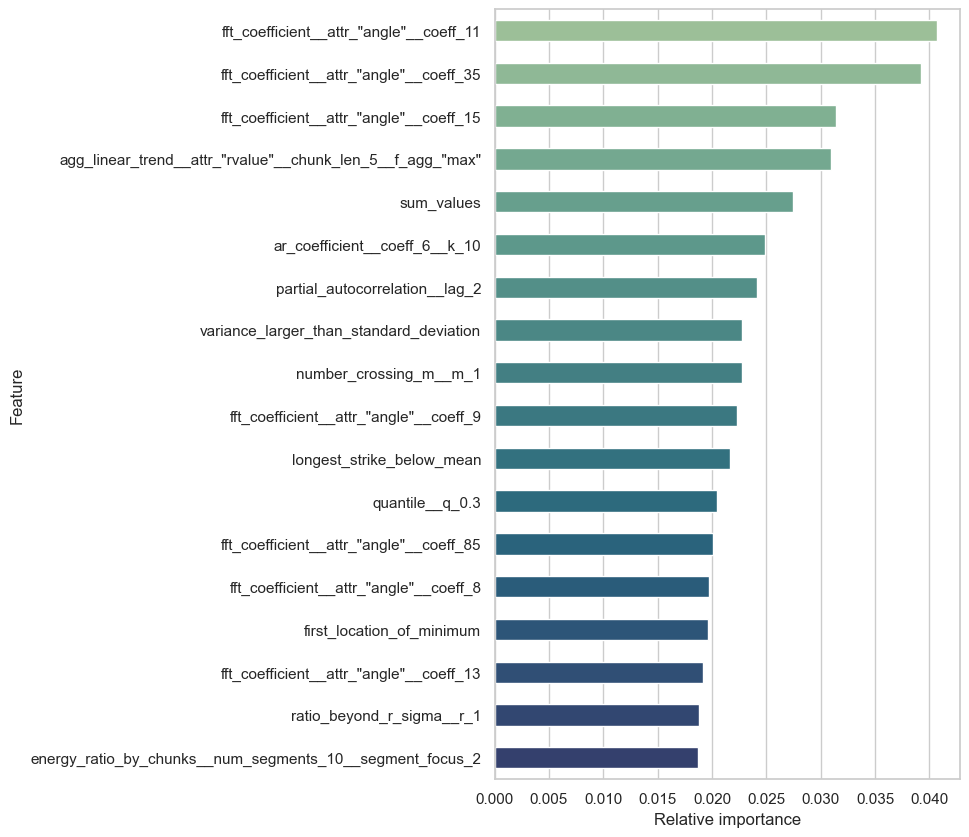

--- Analysing comprehensive features ---


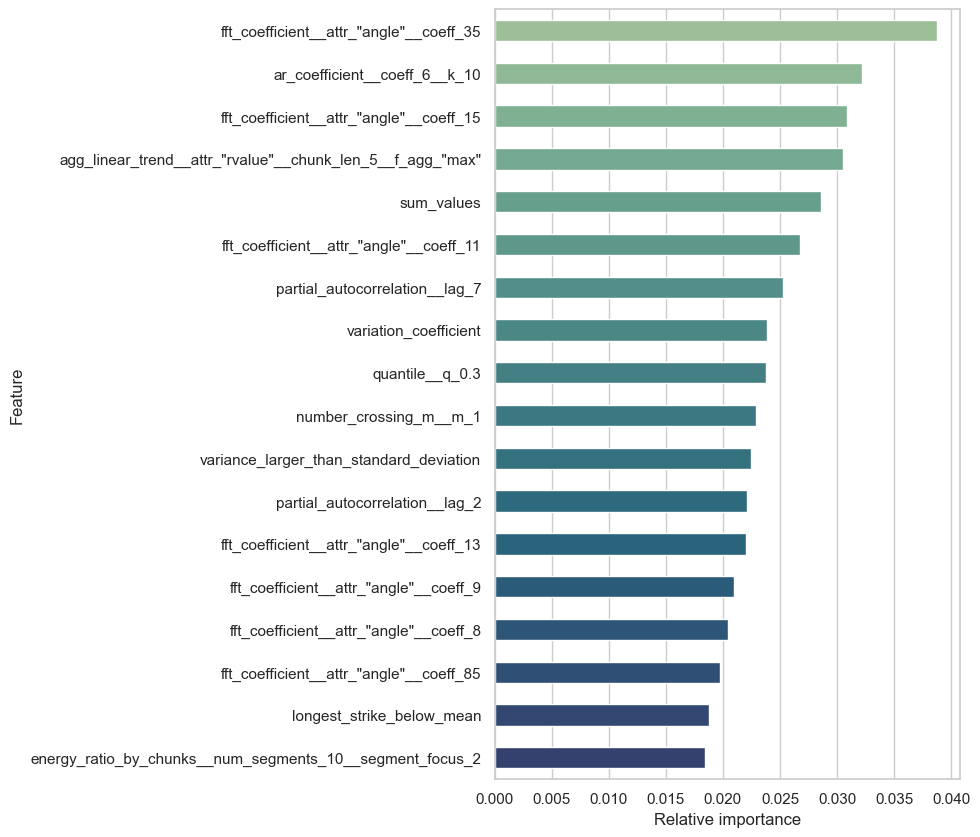

In [75]:
sns.set_theme(style="whitegrid")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    print(f"--- Analysing {feature_set} features ---")
    meta_X, meta_y = load_metadataset(feature_set, problem_type="regression")
    y_encoder = LabelEncoder().fit(meta_y)
    meta_y_encoded = y_encoder.transform(meta_y)

    xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
    feature_importances = xgb.feature_importances_
    
    importance_map = dict()
    for fname, fimp in zip(meta_X.columns, feature_importances):
        fname_split = fname.split("_")
        if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
            fname_proper = "_".join(fname_split[1:])
            importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
        else:
            importance_map[fname] = fimp + importance_map.get(fname, 0.)

    imps = np.array(list(importance_map.values()))
    names = np.array(list(importance_map.keys()))
    order = np.argsort(-imps)
    n_features = 18

    fig, ax = plt.subplots(figsize=(6, 10))
    
    sns.barplot(x=imps[order][:n_features], y=names[order][:n_features], palette="crest", width=0.5, ax=ax)
    ax.set_xlabel("Relative importance")
    ax.set_ylabel("Feature")

    plt.show()
    


In [4]:
print("--- Analysing label features ---")
meta_X, meta_y = load_metadataset("minimal", problem_type="regression")
label_columns = [c for c in meta_X.columns if c.startswith("label_")]
meta_X = meta_X[label_columns]

anova_selector = SelectFpr(alpha=0.05).fit(meta_X, meta_y)
for n, i in enumerate(np.argsort(anova_selector.pvalues_)):
    print(f"{n+1}. {meta_X.columns[i]}: {100 - 100 * anova_selector.pvalues_[i]:.5f}% confidence")


--- Analysing label features ---
1. label_median: 22.07641% confidence
2. label_minimum: 16.13110% confidence
3. label_mean: 11.91450% confidence
4. label_maximum: 7.71725% confidence
5. label_standard_deviation: 7.28307% confidence
6. label_root_mean_square: 3.53245% confidence


In [76]:
print("--- Best estimator accuracies ---")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    accs = np.empty(5)
    for i in range(5):
        results = pd.read_csv(f"./results/regression_label_{feature_set}_xgb_{i+1}.csv")
        accs[i] = accuracy_score(results["best_estimator"], results["predicted_estimator"])
    
    print(f"{feature_set}: {100 * np.mean(accs):.5f}%")

--- Best estimator accuracies ---
catch22: 32.25806%
minimal: 37.09677%
efficient: 37.09677%
comprehensive: 38.70968%


In [136]:
results = dict()
rmses = load_rmses()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    rmse = None
    for i in range(5):
        res = pd.read_csv(f"./results/regression_label_{feature_set}_xgb_{i+1}.csv")
        if rmse is None:
            rmse = res["rmse"]
        else:
            rmse = rmse + res["rmse"]
    rmse = rmse / 5

    results[feature_set] = rmse

results["datasets"] = res["dataset"]
results["baseline"] = build_baseline(rmses)
results["topline"] = build_regression_topline(rmses) - 1e-15

results = pd.DataFrame(results).set_index("datasets")
results_normalized = ((results.T - results.T.mean()) / results.T.std()).T
results_normalized

,catch22,minimal,efficient,comprehensive,baseline,topline
datasets,,,,,,
AcousticContaminationMadrid-no-missing,0.059007,-1.227003,0.908967,0.908967,0.577065,-1.227003
AluminiumConcentration,0.063119,0.063119,0.063119,0.063119,1.447325,-1.699799
AppliancesEnergy,-0.452707,1.850365,-0.452707,-0.452707,0.402016,-0.894261
BIDMC32HR,-0.408248,-0.408248,-0.408248,-0.408248,2.041241,-0.408248
BIDMC32RR,-0.400738,-0.400738,-0.400738,-0.400738,2.041014,-0.438063
...,...,...,...,...,...,...
TetuanEnergyConsumption,-0.383112,-0.383112,-0.383112,-0.383112,2.038761,-0.506314
VentilatorPressure,0.685326,-0.608043,-0.608043,-0.608043,1.746844,-0.608043
WaveDataTension,-0.653625,-0.616273,1.262783,1.262783,-0.299667,-0.956002


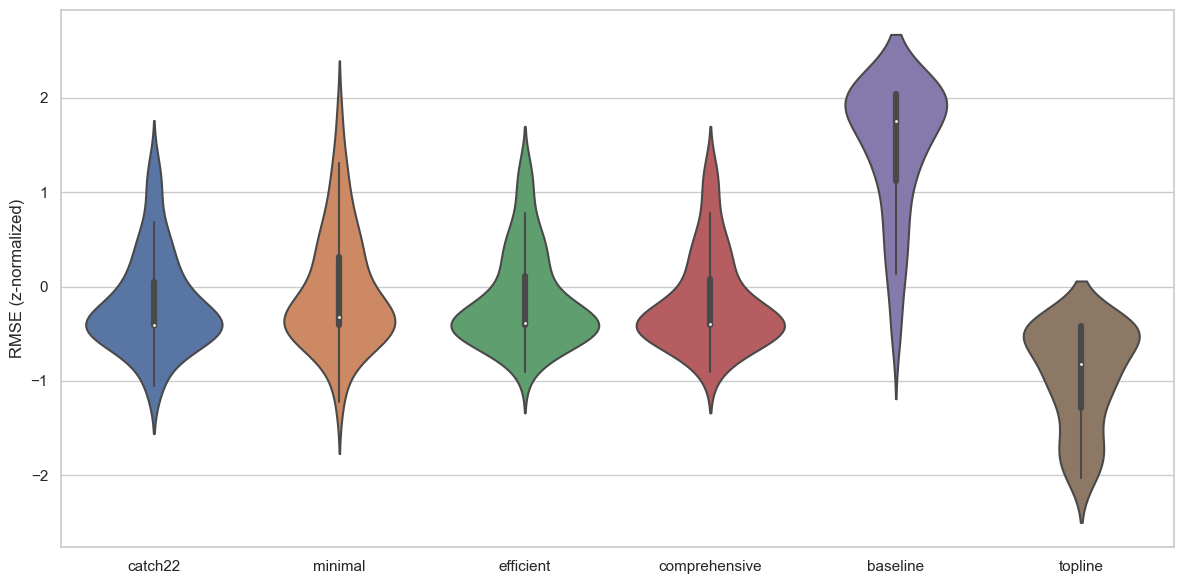

In [137]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.violinplot(data=results_normalized, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE (z-normalized)")

plt.show()

Processing topline, baseline:   0%|          | 0/6 [00:00<?, ?it/s]       


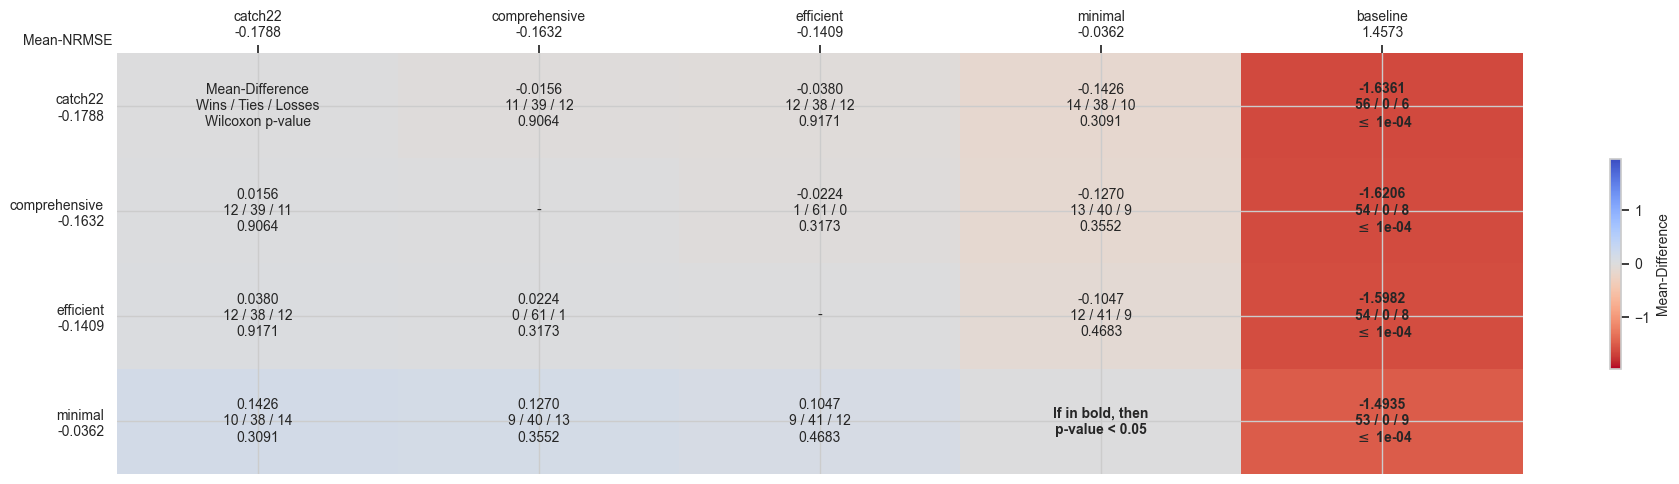

In [138]:
MCM.compare(
    df_results=results_normalized,
    output_dir="results/",
    used_statistic="NRMSE",
    order_WinTieLoss="lower",
    order_better="increasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm_r",
    excluded_row_comparates=["baseline", "topline"],
    excluded_col_comparates=["topline"],
    colorbar_orientation="vertical",
)

In [139]:
print("--- Metamodel accuracies ---")
for model in ["svm", "nb", "1nn", "5nn"]:
    res = pd.read_csv(f"results/regression_label_catch22_{model}.csv")
    print(f"{model}: {100 * accuracy_score(res['best_estimator'], res['predicted_estimator']):.5f}%")

for model in ["rf", "xgb"]:
    acc = 0.
    for i in range(5):
        res = pd.read_csv(f"results/regression_label_catch22_{model}_{i+1}.csv")
        acc += accuracy_score(res['best_estimator'], res['predicted_estimator'])
    acc /= 5
    print(f"{model}: {100 * acc:.5f}%")

--- Metamodel accuracies ---
svm: 37.09677%
nb: 11.29032%
1nn: 30.64516%
5nn: 25.80645%
rf: 36.12903%
xgb: 32.25806%


In [140]:
results = dict()
for model in ["svm", "nb", "1nn", "5nn"]:
    res = pd.read_csv(f"results/regression_label_catch22_{model}.csv")
    results[model] = res["rmse"]

for model in ["rf", "xgb"]:
    rmse = None
    for i in range(5):
        res = pd.read_csv(f"results/regression_label_catch22_{model}_{i+1}.csv")
        if rmse is None:
            rmse = res["rmse"]
        else:
            rmse = rmse + res["rmse"]
    rmse = rmse / 5
    results[model] = rmse

rmses = load_rmses()
results["datasets"] = rmses.columns
results["drcif"] = rmses.loc["DrCIF"].reset_index(drop=True)
results["freshprince"] = rmses.loc["FreshPRINCE"].reset_index(drop=True)

results = pd.DataFrame(results).set_index("datasets")
results_normalized = ((results.T - results.T.mean()) / results.T.std()).T
results_normalized

,svm,nb,1nn,5nn,rf,xgb,drcif,freshprince
datasets,,,,,,,,
AcousticContaminationMadrid-no-missing,-0.011943,1.252456,1.252456,-0.011943,-0.735345,-0.011943,0.086708,-1.820447
AluminiumConcentration,-0.174560,-1.274074,-0.174560,-0.174560,-0.134837,-0.174560,-0.174560,2.281709
AppliancesEnergy,-0.341843,0.198299,2.373321,-0.341843,-0.341843,-0.341843,-0.341843,-0.862405
BIDMC32HR,-0.608461,-0.048415,-0.608461,-0.608461,-0.608461,-0.608461,1.975623,1.115098
BIDMC32RR,-0.495479,-0.495479,-0.495479,-0.495479,-0.495479,-0.495479,2.230754,0.742119
...,...,...,...,...,...,...,...,...
TetuanEnergyConsumption,-0.497003,2.280551,-0.477993,-0.477993,0.625425,-0.477993,-0.497003,-0.477993
VentilatorPressure,-0.612346,2.406905,-0.612346,-0.612346,-0.150208,-0.150208,-0.119242,-0.150208
WaveDataTension,-0.449711,2.044842,-0.449711,-0.449711,1.047021,-0.449711,-0.449711,-0.843310


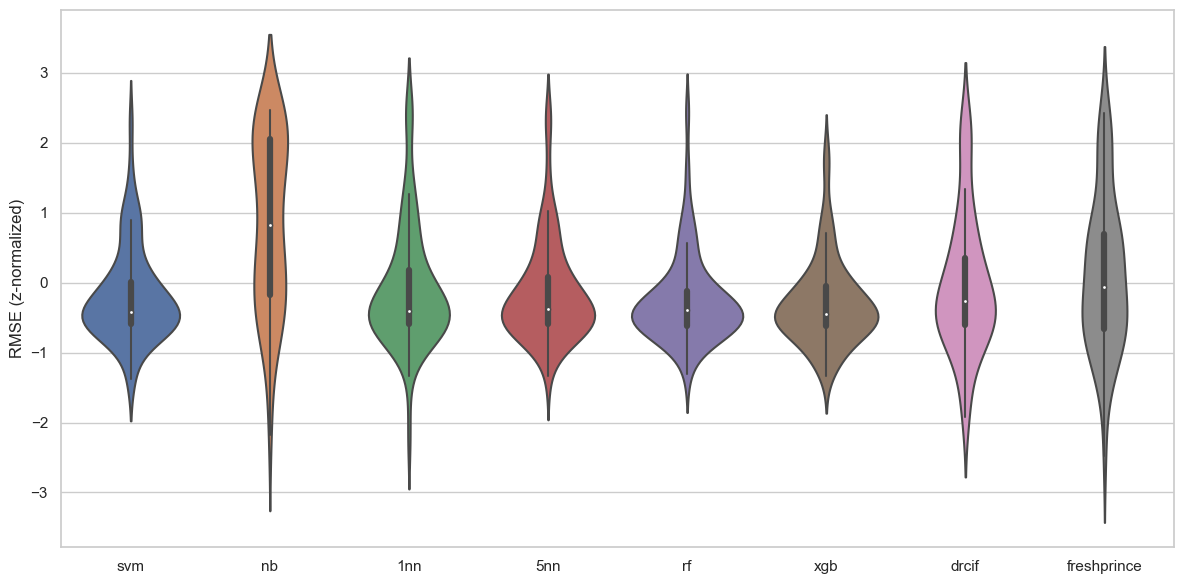

In [141]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.violinplot(data=results_normalized, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE (z-normalized)")

plt.show()

Processing freshprince, drcif:   0%|          | 0/8 [00:00<?, ?it/s]


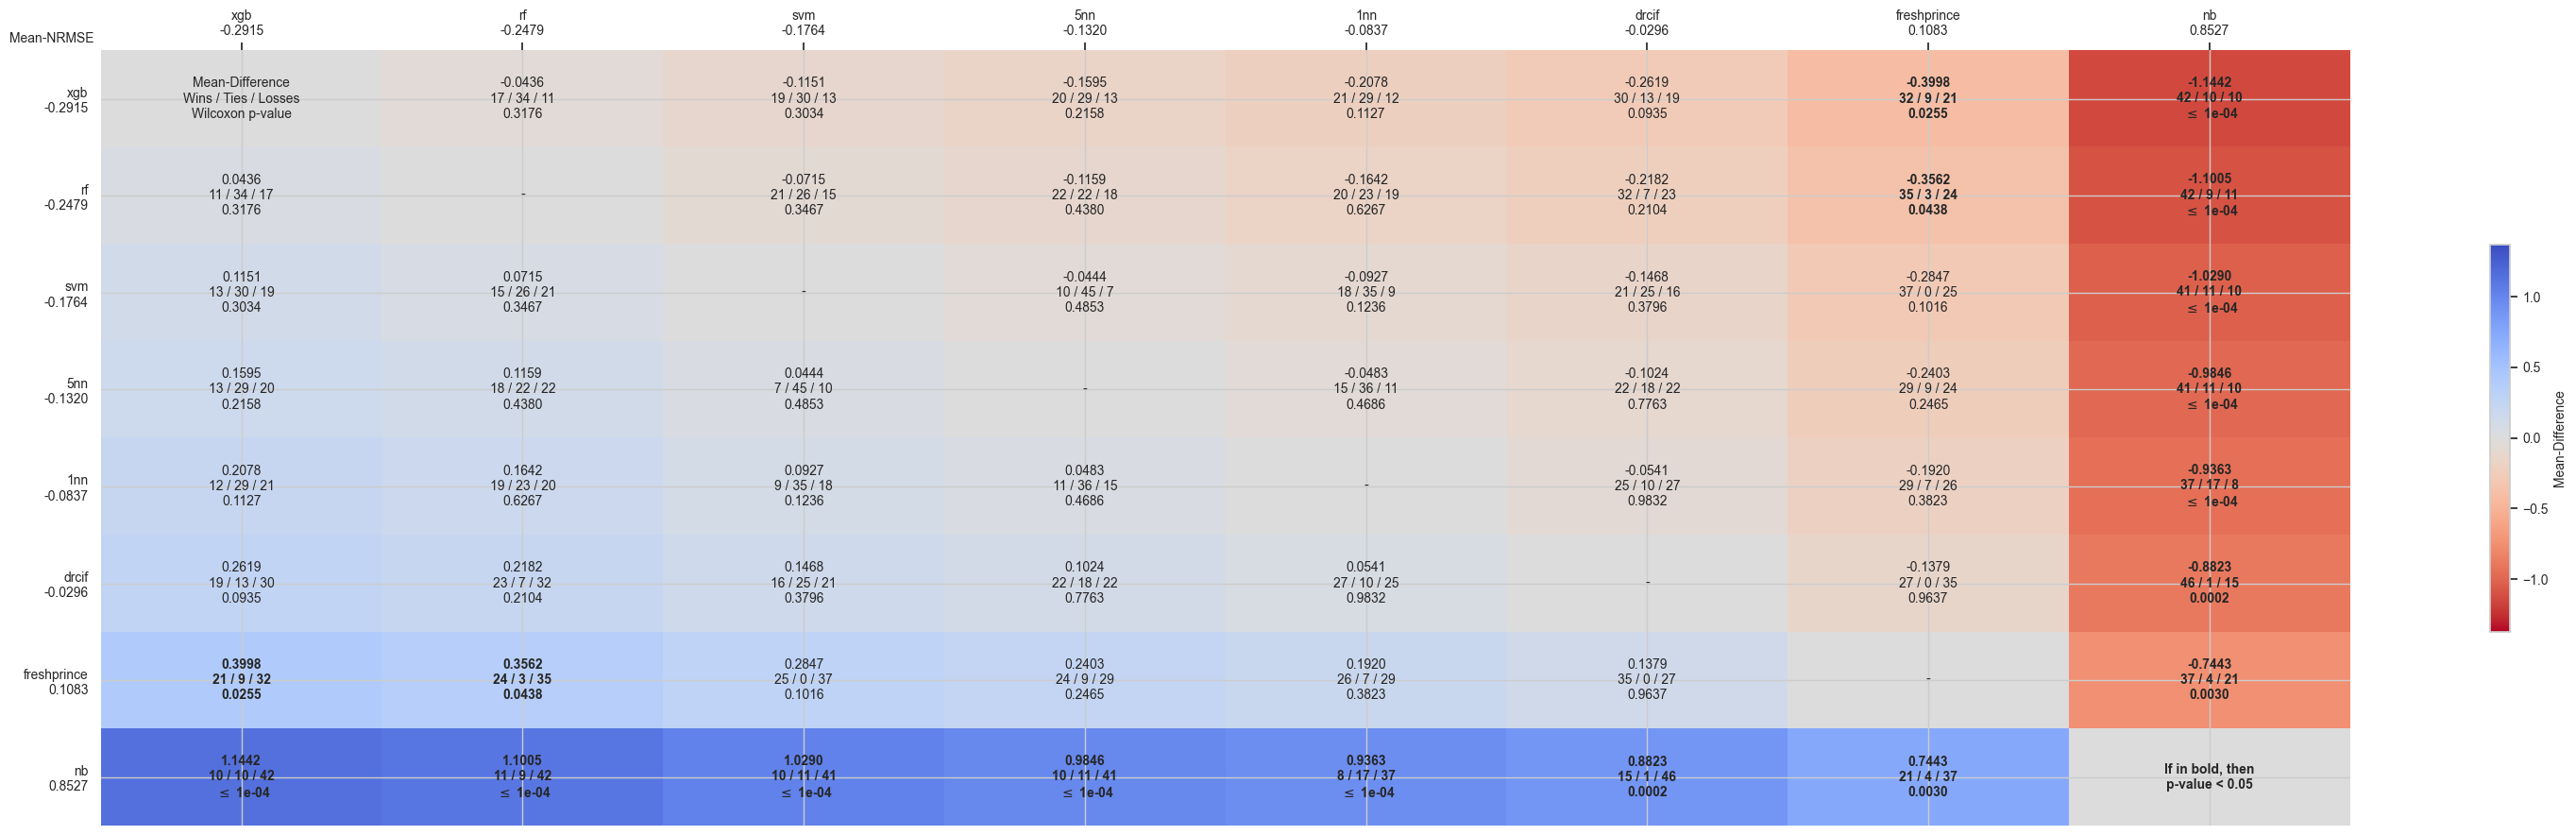

In [142]:
MCM.compare(
    df_results=results_normalized,
    output_dir="results/",
    used_statistic="NRMSE",
    order_WinTieLoss="lower",
    order_better="increasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm_r",
    colorbar_orientation="vertical",
)